# Proje Yapısı
- Kütüphanelerin eklenmesi
- Veri görselleştirme
- Data augmentation + preprocessing
- CNN modeli oluşturma
- callbacks
- Traning
- Model Evaluation

# Veri Seti Tanıma:

- çiçek görüntülerinden oluşur.
- rgb olmak üzere 3 kanallıdır her görüntü.
- 224x224 piksellerden oluşmaktadır.

# 1-) Kütüphanelerin Dahil Edilmesi


In [ ]:
from tensorflow_datasets import load
from tensorflow.keras import datasets
from tensorflow.data import AUTOTUNE # veri seti optimizasyonu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten, # çok boyutlu veriyi tek boyutlu hale getirir
    Dense, # fully connected layer
    Dropout, # overfit önleme(nöron kapatma)
    BatchNormalization,
)

from tensorflow.keras.optimizers import Adam #optimizer
from tensorflow.keras.callbacks import(
    EarlyStopping, #
    ReduceLROnPlateau, # öğrenme oranı azaltımı
    ModelCheckpoint, #model kaydetme

)

import tensorflow as tf
import matplotlib.pyplot as plt




# 2-) Veri Seti Yükleme

In [ ]:
(ds_train,ds_validation), ds_info=load(
    "tf_flowers",
    split= ["train[:80%]", # eğitim için %80,test için %20
           "train[80%:]"],
    as_supervised = True, # Veri setinin görsel etiket çiftinin olması
    with_info = True, # veri setinin bilgileri


)

print(ds_info.features)
print("Sınıf sayısı:",ds_info.features["label"].num_classes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.4PQ5T6_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})
Sınıf sayısı: 5


# Colour channel --> 3
# Classification Class --> 5

# 3-) Veri Görselleştirme

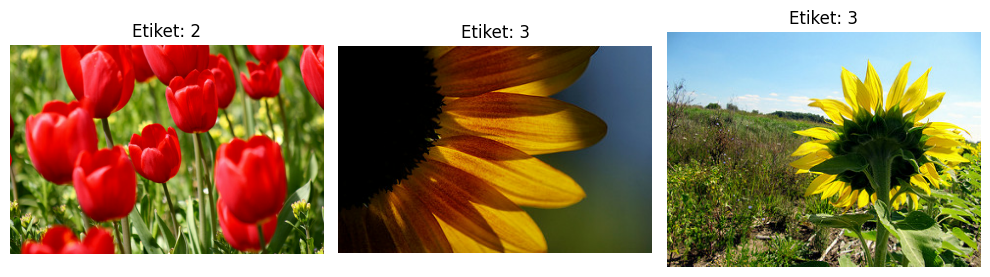

In [ ]:
fig = plt.figure(figsize=(10,5))
for i,(img,label) in enumerate(ds_train.take(3)):
  ax = fig.add_subplot(1,3,i+1)
  ax.imshow(img.numpy().astype("uint8"))
  ax.set_title(f"Etiket: {label.numpy()}")
  ax.axis("off")

plt.tight_layout()
plt.show()

# 4-) Data Augmentation

In [ ]:
IMG_SIZE = (180,180)

def preprocess_train(image,label):
  image = image[..., :3]   # RGBA -> RGB dönüşümü

  """
  resize,random fli,brightness,contarst,crop,normalize
  """

  # boyutlandırma
  image = tf.image.resize(image, IMG_SIZE)

  # shape sabitleme (random_crop için zorunlu)
  image = tf.reshape(image, (180,180,3))

  # yatay olarak rastgele çevirme
  image = tf.image.random_flip_left_right(image)

  # rastgele parlaklık
  image = tf.image.random_brightness(image, 0.1)

  # alt ve üst sınırlar rastgele kontrast
  image = tf.image.random_contrast(image, 0.8, 1.2)

  # rastgele kırpma
  image = tf.image.random_crop(image, size=(160,160,3))

  # tekrar boyutlandırma
  image = tf.image.resize(image, IMG_SIZE)

  # Normalizasyon
  image = tf.cast(image, tf.float32) / 255.0

  label = tf.cast(label, tf.int32)
  label = tf.reshape(label, ())


  return image, label


def preprocess_val(image,label):
  """
  resize,normalizasyon
  """
  image = image[..., :3]
  image = tf.image.resize(image, IMG_SIZE)
  image = tf.cast(image, tf.float32) / 255.0

  label = tf.cast(label, tf.int32)
  label = tf.reshape(label, ())
  return image, label


# Veri setini hazırlama
ds_train = (
    ds_train
    .map(preprocess_train, num_parallel_calls=AUTOTUNE)   # preprocessor + augmentation
    .shuffle(1000)                                        # karıştırma
    .batch(32)                                            # batch size
    .prefetch(AUTOTUNE)                                   # veri setini önceden hazırlamak
)

ds_validation = (
    ds_validation
    .map(preprocess_val, num_parallel_calls=AUTOTUNE)     # preprocessor
    .batch(32)
    .prefetch(AUTOTUNE)
)


# 5-) CNN Modeli Oluşturma

In [ ]:
model = Sequential([
    #Feature Extraction Layers
    Conv2D(32,(3,3),activation="relu",input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2), # 2X2 MAX pooling
    Conv2D(64,(3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3), activation="relu"),
    MaxPooling2D(2,2),

    #Classfication Layers
    Flatten(), # vektöre çevirme
    Dense(128,activation="relu"),
    Dropout(0.5), # overfitting engelleme için
    Dense(5,activation="softmax")


])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 6-) Callbacks

In [ ]:
from IPython.extensions.storemagic import restore_aliases
callbacks2=[
    # Eğer val loss 3 epoch boyunca iyileşmez ise eğitimi durdur ve en iyi ağırlıkları yükle
    EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True),

    # val loss 2 epeoch boyunca iyileşmez ise learning rate 0.2 çarpanı ile azalt
    ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_lr=1e-9),

    # Her epoch sonunda eğer model daha iyi ise Modeli kaydetme
    ModelCheckpoint("best_model.h5",save_best_only=True)


]

# 7-) Model Derleme

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,621 (25.36 MB)

 Trainable params: 6,647,621 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

None


# 8-) Training

In [ ]:
history = model.fit(
    ds_train,
    validation_data = ds_validation,
    epochs=10,
    callbacks=callbacks2,
    verbose=1 # eğitim ilerlemesini göster

)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3276 - loss: 1.5659

92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.3284 - loss: 1.5638 - val_accuracy: 0.5286 - val_loss: 1.1343 - learning_rate: 0.0010
Epoch 2/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5018 - loss: 1.1744

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5020 - loss: 1.1738 - val_accuracy: 0.5967 - val_loss: 1.0219 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5721 - loss: 1.0842

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5722 - loss: 1.0840 - val_accuracy: 0.6458 - val_loss: 0.9506 - learning_rate: 0.0010
Epoch 4/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5895 - loss: 1.0062

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5899 - loss: 1.0054 - val_accuracy: 0.6431 - val_loss: 0.9152 - learning_rate: 0.0010
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6485 - loss: 0.9439

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6485 - loss: 0.9437 - val_accuracy: 0.6703 - val_loss: 0.8490 - learning_rate: 0.0010
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6524 - loss: 0.8851 - val_accuracy: 0.6213 - val_loss: 0.9411 - learning_rate: 0.0010
Epoch 7/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6720 - loss: 0.8562

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6722 - loss: 0.8557 - val_accuracy: 0.6866 - val_loss: 0.8219 - learning_rate: 0.0010
Epoch 8/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7047 - loss: 0.8121

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7046 - loss: 0.8117 - val_accuracy: 0.7071 - val_loss: 0.7520 - learning_rate: 0.0010
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6994 - loss: 0.7766 - val_accuracy: 0.7016 - val_loss: 0.8208 - learning_rate: 0.0010
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7005 - loss: 0.7725
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7007 - loss: 0.7724 - val_accuracy: 0.6935 - val_loss: 0.7750 - learning_rate: 0.0010


# 9-) Doğruluk Grafiği

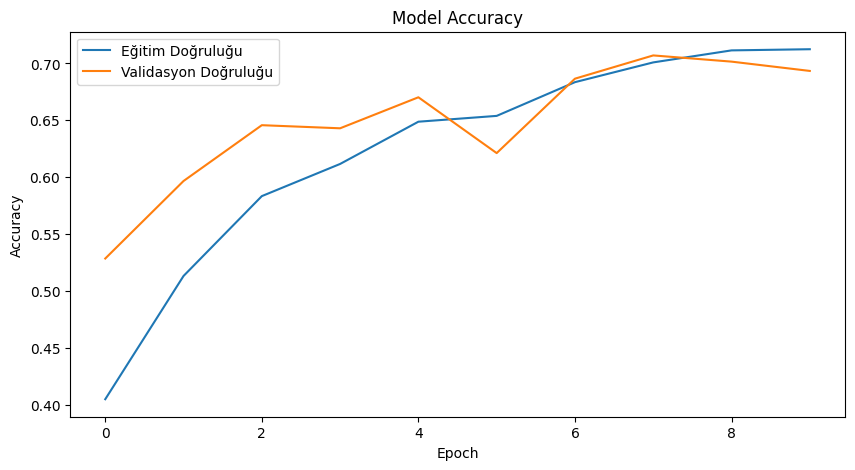

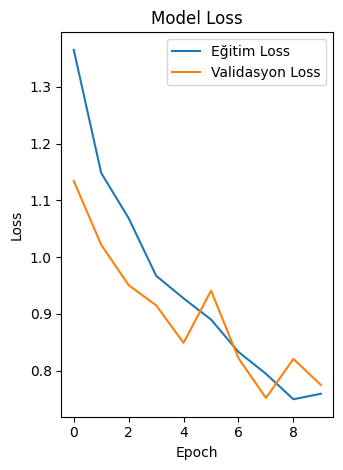

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],label="Eğitim Doğruluğu")
plt.plot(history.history["val_accuracy"],label = "Validasyon Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

#loss plot

plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Eğitim Loss")
plt.plot(history.history["val_loss"],label="Validasyon Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.legend()
plt.tight_layout()
plt.show()